## Kaggle Cats vs Dogs Compitition

In [1]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D


#### ImageDataGenerator is used below to add data augmentation parameters. Data augmentation is used for creating more training data points by applying parameters such as rotating the image, horizontally flipping the image etc.

In [60]:

train_datagen = ImageDataGenerator(rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   validation_split=0.25,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

#### Flow from directory is used to pick images from the directory, augment the images and put into the train/validation split. Test data is not augmented in any manner. The class mode is binary as this is a binary classifcation problem.

In [61]:
#Training, validation and test sets
train_dir = 'D:\\pankh\\train'

# Flow training and validation images in batches of 30 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 10, 
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224), 
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         class_mode = 'binary', 
                                                         target_size = (224, 224), 
                                                         subset='validation')

# Test images.
test_dir = 'D:\\pankh\\test2'
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size = (224, 224), 
                                                  shuffle = False,
                                                 class_mode = None)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


#### VGG-16: I am loading the pre-trained VGG-16 model below and using the weights that from the same (through layers.trainable=False). The following layers are added to the pre-existing VGG-16 model: a fully connected hidden layer with activation function ReLu, a droput layer with droput rate 0.5 combat overfitting on the training data and the output layer with the sigmoid activation function (as this is a binary classification problem). 'Adam' is used as the gradient descent optimizer as it is adaptive and the loss is calculated on cross entropy (as it is a classification problem).

In [33]:
# VGG-16 Base Model
base_model = VGG16(input_shape = (224, 224, 3), 
include_top = False, # Leaving out the last layer.
weights = 'imagenet')

# Trainable is set as false so that the pre trained weights are used.
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [9]:
vgg = model.fit(train_generator, 
                steps_per_epoch = 100, 
                validation_data = validation_generator, 
                epochs = 10)

Epoch 1/10
100/100 [==============================] - 128s 1s/step - loss: 1.1894 - acc: 0.7140 - val_loss: 0.3434 - val_acc: 0.8488
Epoch 2/10
100/100 [==============================] - 90s 902ms/step - loss: 0.3806 - acc: 0.8200 - val_loss: 0.3067 - val_acc: 0.8682
Epoch 3/10
100/100 [==============================] - 91s 911ms/step - loss: 0.3568 - acc: 0.8363 - val_loss: 0.3001 - val_acc: 0.8740
Epoch 4/10
100/100 [==============================] - 91s 914ms/step - loss: 0.3672 - acc: 0.8410 - val_loss: 0.3000 - val_acc: 0.8692
Epoch 5/10
100/100 [==============================] - 92s 920ms/step - loss: 0.3829 - acc: 0.8281 - val_loss: 0.3065 - val_acc: 0.8718
Epoch 6/10
100/100 [==============================] - 92s 921ms/step - loss: 0.3482 - acc: 0.8447 - val_loss: 0.2866 - val_acc: 0.8768
Epoch 7/10
100/100 [==============================] - 93s 931ms/step - loss: 0.3274 - acc: 0.8477 - val_loss: 0.3104 - val_acc: 0.8606
Epoch 8/10
100/100 [==============================] - 93s

#### We can see from above that the validation accuracy is 0.85 and the validation loss is 0.31. As this is not very good, a second pre-trained model is implemented below.

#### ResNet50: The same methodology is followed as for VGG-16.

In [43]:
base_model = ResNet50(include_top = False,
weights = 'imagenet',
pooling = 'max')
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
model = Model(base_model.input, x)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

#### Due to computational constraints, I ran the model three different times, changing the number of epochs each time, first 10 epochs, then 5 epochs and then 2 epochs (as shown in the code below), as the model seemed unstable. Since the weights are saved across the multiple runs (unless the session is terminated), the subsequent epochs built upon the previous epochs.

In [56]:
resnet = model.fit(train_generator, 
                   validation_data = validation_generator, 
                   steps_per_epoch = 200, 
                   epochs = 2)

Epoch 1/2
200/200 [==============================] - 88s 442ms/step - loss: 0.1671 - acc: 0.9340 - val_loss: 0.1254 - val_acc: 0.9562
Epoch 2/2
200/200 [==============================] - 90s 450ms/step - loss: 0.1404 - acc: 0.9420 - val_loss: 0.2120 - val_acc: 0.9122


#### As this model is performing much better than VGG-16, it is chosen as the final model.

#### Final Model:

In [68]:
train_datagen = ImageDataGenerator(rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   validation_split=0.01,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

In [69]:
#Training, validation and test sets
train_dir = 'D:\\pankh\\train'

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 10, 
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224), 
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         class_mode = 'binary', 
                                                         target_size = (224, 224), 
                                                         subset='validation')

test_dir = 'D:\\pankh\\test2'
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size = (224, 224), 
                                                  shuffle = False,
                                                  class_mode = None)

Found 24750 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [70]:
base_model = ResNet50(include_top = False,
weights = 'imagenet',
pooling = 'max')
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
model = Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [71]:
final = model.fit(train_generator, 
                  validation_data = validation_generator, 
                  steps_per_epoch = 200, 
                  epochs = 20)

Epoch 1/20
200/200 [==============================] - 30s 140ms/step - loss: 2.1486 - acc: 0.8585 - val_loss: 0.4605 - val_acc: 0.8800
Epoch 2/20
200/200 [==============================] - 84s 421ms/step - loss: 0.2935 - acc: 0.9015 - val_loss: 0.1970 - val_acc: 0.9120
Epoch 3/20
200/200 [==============================] - 91s 456ms/step - loss: 0.2060 - acc: 0.9265 - val_loss: 0.1089 - val_acc: 0.9520
Epoch 4/20
200/200 [==============================] - 90s 453ms/step - loss: 0.2038 - acc: 0.9225 - val_loss: 0.1362 - val_acc: 0.9520
Epoch 5/20
200/200 [==============================] - 25s 124ms/step - loss: 0.1704 - acc: 0.9285 - val_loss: 0.2129 - val_acc: 0.9040
Epoch 6/20
200/200 [==============================] - 25s 127ms/step - loss: 0.1637 - acc: 0.9325 - val_loss: 0.1016 - val_acc: 0.9560
Epoch 7/20
200/200 [==============================] - 25s 125ms/step - loss: 0.1558 - acc: 0.9380 - val_loss: 0.1668 - val_acc: 0.9280
Epoch 8/20
200/200 [==============================] - 2

In [76]:
final = model.fit(train_generator, 
                  validation_data = validation_generator, 
                  steps_per_epoch = 200, 
                  epochs = 1)

200/200 [==============================] - 26s 129ms/step - loss: 0.1344 - acc: 0.9450 - val_loss: 0.0927 - val_acc: 0.9560


In [77]:
y_pred = model.predict(test_generator)

In [78]:
# Exporting file for final submission on Kaggle.
import pandas as pd
y_pred_df = pd.DataFrame({'id': test_generator.filenames, 'label': y_pred.reshape(-1).clip(min = 0.02, max = 0.98)})
y_pred_df['id'] = y_pred_df['id'].apply(lambda x: x.replace('test\\', '').replace('.jpg', ''))

y_pred_df.to_csv('submission_q.csv')

#### On submitting this file to Kaggle, the final score I get is 0.09 (as shown below).

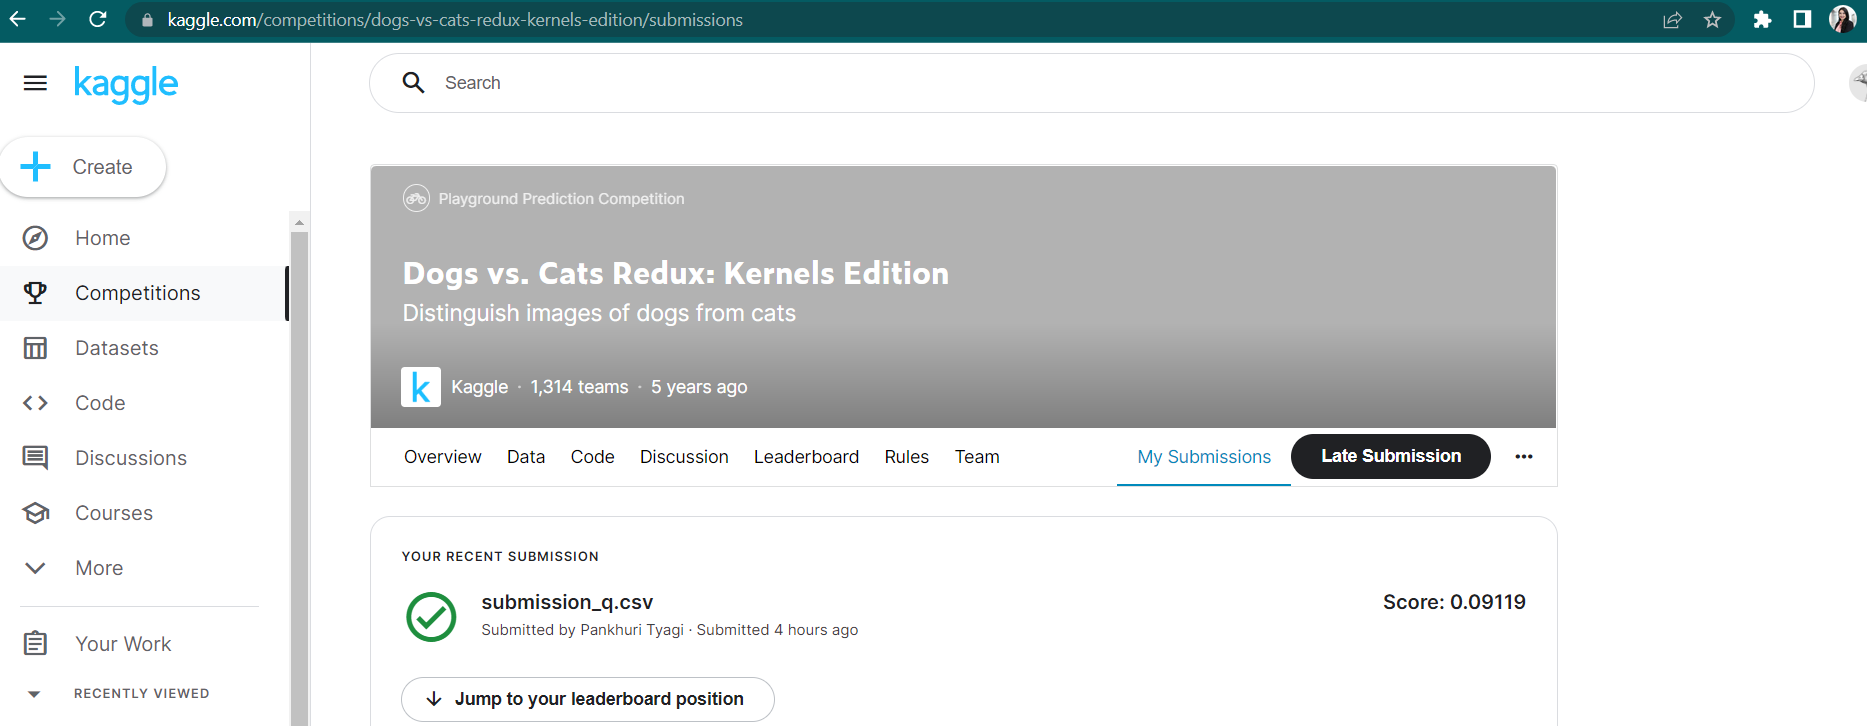